# Twitter Personality Classification With Fastai

## Initial setup and look at the data

In [1]:
# initial installation for twitter api wrapper
# no need to run this cell after twython is installed
#!pip install twython

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *
import json
from twython import Twython

In [10]:
# setting the master path to the current folder
path = os.getcwd()

# setting the batch size for the model
bs = 12

In [16]:
# this line gets rid of an error in loading this specific csv file into pandas 
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
df = pd.read_csv('mbti_1.csv')

# getting the number of posts per personality
print(df.groupby('type').count())

# pringing an example post
print(df['posts'][0])

      posts
type       
ENFJ    190
ENFP    675
ENTJ    231
ENTP    685
ESFJ     42
ESFP     48
ESTJ     39
ESTP     89
INFJ   1470
INFP   1832
INTJ   1091
INTP   1304
ISFJ    166
ISFP    271
ISTJ    205
ISTP    337
'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure

## Training the language model

In [ ]:
# loading the data for a text databunch to train the language model on the type of language used in the posts
# only need to run this cell once the first time

data_lm = (TextList.from_csv(path, 'mbti_1.csv', cols=1)
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [139]:
# once the databunch is built and saved, it can be loaded using this cell
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

idx,text
0,= xxunk xxmaj on repeat for most of xxunk the perc xxmaj experience immerse you.|||the last thing my xxup infj friend posted on his facebook before committing suicide the next day . xxmaj rest in xxunk http : / / vimeo.com / xxunk xxup xxunk . xxmaj sorry to hear of your distress . xxmaj it 's only natural for a relationship to not be perfection all the time in
1,everything i was too distracted to say . xxmaj to add : xxmaj tea cup or miniature animals with the exception of a mini horse cause they are just bad ass . xxmaj paperwork in general because ... xxup |||i think the second definition has much merit in my life . xxmaj it is always easy for me to spot high probability of a negative outcome . i hate it
2,... so i do n't think liking non - fiction could really ... |||well i would n't agree to hang out with someone unless i was interested in them . xxmaj whether it 's friendship he wants or more there is nothing you can really do but wait to see what he does / says in the ... |||i'm not a troll . xxmaj god forbid i 'm here looking
3,"|||i'm a girl , but as an xxup infp , the thing i realized about the dating ( except xxup not looking for it obsessively , it gives wrong signals and either attracts people who will use you , or pushes people you like ... xxup |||i would say the beach as well ... xxmaj if she likes wine , you can always get a bottle and make a picnic"
4,"xxup taking xxup over i xxup will xxup never xxup be xxup itch xxup free xxup why xxup me ! ? ! ? ! and then i realize that this is entirely not ... |||ahh ... xxmaj absent - mindedness yes it plagues me so , but i 've gotten alot better about it ! a few things i did were to 1 . xxmaj check , xxmaj re -"


In [140]:
# this is loading the databunch into a language model learner object
# the base for this is a model that was trained on the text of wikipedia 
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


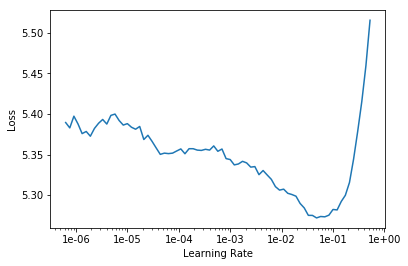

In [141]:
# finding and plotting the ideal learning rate
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
# training the final layer of the language model
learn.fit_one_cycle(1, 4e-2, moms=(0.8,0.7))
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

In [ ]:
# unfreezing all the hidden layers and training the language model for 10 epochs on the social media posts
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))
learn.save('fine_tuned')

# saving the encoder of the model so that the classifier can use it
learn.save_encoder('fine_tuned_enc')

# this takes several hours, so i left it running over night and let the computer shut down after the training was complete
!sudo shutdown now

## Training the Classifier

In [ ]:
# loading the data to a databunch that is marked for classification and then saving
# only need to run this cell once the first time
data_clas = TextClasDataBunch.from_csv(path, 'mbti_1.csv', vocab=data_lm.train_ds.vocab, bs=bs)
data_clas.save('data_clas.pkl')

In [20]:
# use this cell to load the databunch for the classification model
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()

text,target
"xxbos xxup mbti : xxmaj subtype : xxmaj compatible xxmaj matches : xxmaj cognitive xxmaj functions : xxmaj global 5 : xxmaj enneagram xxmaj xxunk : xxmaj variant : xxmaj archetype : xxmaj xxunk : xxmaj xxunk : / / www.youtube.com / watch?v = xxunk you xxmaj xxunk , xxmaj borderline , or xxmaj narcissistic ? i am xxmaj borderline . xxmaj also , i am the xxmaj hermit but",INFP
"xxbos ' xxmaj why not xxmaj how do girls like to be flirted with ? instead ? xxmaj honestly , smile . xxup that is how guys should flirt with a woman . xxmaj then say something private , a joke or a comment , that requires you to whisper ... |||and xxup this is why i moved out of my apartment into a one - bedroom home a mile",INFJ
"xxbos ' xxmaj enough so that only risk starvation , jail and / or execution can make me abandon my values . xxmaj that is to say , few circumstances can make me act in a manner contrary to my values . xxmaj this does not mean that ... |||not uncommon . xxmaj probably enneatype 6 , too . xxmaj some people feel awkward and inadequate when they bring up",ENTJ
"xxbos ' i do agree with you that book counterparts , are generally smarter . i just do n't think the writers are very sophisticated at writing appropriate reactions from the characters ( like you xxunk ... |||any thoughts on xxmaj euron xxmaj greyjoy so far ? i 'm thinking xxup esxp . xxmaj kind of funny , because xxup xxunk xxmaj ramsay , xxup xxunk xxmaj joffrey . xxmaj",ISFP
"xxbos ' xxmaj actually , if xxmaj old xxmaj testament xxmaj god were to be tested as something , it would make more sense to be xxup estj if you go by the functions . xxmaj first off , morality is not an f thing . i classify as an xxup infj , but i ... |||didn't really know how to phrase that title so sorry if there 's any",INFJ


In [21]:
# this is loading the databunch into a text classification object
# then loading the encoder for the language model into the classification object
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


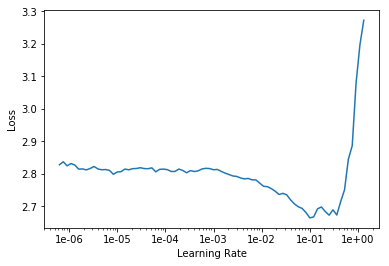

In [22]:
# finding and plotting the ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# training the final layer of the language model
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))
learn.save('first')

In [ ]:
# loading the first trained model
learn.load('first')

In [ ]:
# unfreezing up to the second layer from last and training the model 
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save('second')

In [6]:
# loading the second trained model 
learn.load('second')

In [7]:
# unfreezing up to the third layer from last and training the model 
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))
learn.save('third')

epoch,train_loss,valid_loss,accuracy,time
0,1.679417,3.100661,0.575461,08:55


In [7]:
# loading the third traine model
learn.load('third');

In [8]:
# unfreezing all layers and applying a range of learning rates to the model and letting it train for 6 epochs
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save('final_model')

# this takes a while so i let it run over night and shut down the computer after the process
!sudo shutdown now

epoch,train_loss,valid_loss,accuracy,time
0,1.501034,20.649067,0.576613,20:33
1,1.440918,1.430255,0.607719,20:49
2,1.380199,1.157052,0.680876,20:38
3,1.157137,1.233543,0.713134,21:33
4,1.113260,2.810657,0.735599,21:42
5,0.986813,1.583400,0.730415,20:31


In [9]:
learn.save('final_model')

In [24]:
# this loads the final model for classification
learn.load('final_model')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6939 items)
x: TextList
xxbos ' xxup intp ( i think ) . xxmaj my hobbies vary in intensity , but i think there are a few consistent ones . - reading about pharmacology , psychology , and neural networks - this links into my reading into ... xxup |||isfj https : / / www.youtube.com / xxunk xxmaj yeah , i do give myself too much to think about . xxmaj that seems to be the main cause of exhaustion / frustration . i was an angry baby until i could talk and do things for myself , and i think xxmaj i'm ... |||so , i 'm coming back to vent a bit , well , not entirely to vent , but i 'll see . xxmaj maybe just to think out loud . xxunk thanks for your response earlier ; it was nice . i 'm wondering why i 'm so ... |||i'm not asking for advice on anything in particular . i 'll just vent and hope someone has something to say . xxmaj at the minute , i 'm on holiday from university , in a town where i have two friends . xxmaj my uni ... |||- be

In [8]:
learn.export('exported_model')

In [11]:
# testing the classsification model based on a single line of text
learn.predict("Got a thank you basket from a kind patient!")

(Category ENFP,
 tensor(1),
 tensor([0.1626, 0.3523, 0.0014, 0.0044, 0.0381, 0.0161, 0.0353, 0.0148, 0.0540,
         0.1195, 0.0056, 0.0137, 0.0706, 0.0567, 0.0448, 0.0102]))

In [25]:
# writing a short function to clean up the predicitons. 
# the description of the personalities comes from https://www.16personalities.com/

def predict_personailty(words):
    
    t = t = {'INTJ':'INTJ - Architect - Imaginative and stratigic thinkers with a plan for everything.',
    'INTP':'INTP - Logician - Innovative inventors with an unquenchable thirst for knowledge.',
    'ENTJ':'ENTJ - Commander - Bold, imaginative, and strong willed leaders, always finding a way - or making one.',
    'ENTP':'ENTP - Debater - Smart and curious thinkers who cannot resist an intellectual challenge.',
    'INFJ':'INFJ - Advocate - Quiet and mystical, yet very inspiring and tireless idealists.',
    'INFP':'INFP - Mediator - Poetic, kind, and altruistic people, always eager to help a good cause.',
    'ENFJ':'ENFJ - Protagonist - Charismatic and inspiring leaders, able to mesmerize their listeners.',
    'ENFP':'ENFP - Campaigner - Enthusiastic, creative, and sociable free spirits, who can always find a reason to smile.',
    'ISTJ':'ISTJ - Logistician - Practical and fact-minded individuals, whose reliability cannot be doubted.',
    'ISFJ':'ISFJ - Defender - Very dedicated and warm protectors, always ready to defend their loved ones.',
    'ESTJ':'ESTJ - Executive - Excellent administrators, unsurpassed at managing things - or people.',
    'ESFJ':'ESFJ - Consul - Extraordinarily caring, social, and popular people, always eager to help.',
    'ISTP':'ISTP - Virtuoso - Bold and practical experimenters, masters of all kinds of tools.',
    'ISFP':'ISFP - Adventurer - Flexible and charming artists, always ready to explore and experience something new.',
    'ESTP':'ESTP - Entrepreneur - Smart, energetic, and very perceptive people, who truly enjoy living on the edge.',
    'ESFP':'ESFP - Entertainer - Spontaneous, energetic, and enthusiastic people - life is never boring around them.'}
    
    pred = learn.predict(words)
    pred = str(pred[0])
    return t.get(pred, 0)

predict_personailty('''let's go eat!!!''')

'ENTJ - Commander - Bold, imaginative, and strong willed leaders, always finding a way - or making one.'

## Getting and classifying the data from Twitter

In [66]:
#this loads my twitter api keys from a json file (not included in repo)

with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

twitter = Twython(creds['CONSUMER_KEY'],
                  creds['CONSUMER_SECRET'],
                  creds['ACCESS_TOKEN'],
                  creds['ACCESS_SECRET'])

In [68]:
# writing a short function to search twitter for multiple terms in a list and then return the results into a dataframe 

def search_twitter(arg_list):
    
    df = pd.DataFrame()
    
    for i in arg_list:
        params = {'q':i,
                  'result_type':'mixed',
                  'count':100,
                  'lang':'en'}

        dict_ = {'text': [], 'search': []}

        for status in twitter.search(**params)['statuses']:
            dict_['text'].append(status['text'])
            dict_['search'].append(i)
        df_i = pd.DataFrame(dict_)
        df = df.append(df_i)
    
    return df

# these are the terms i used to search twitter
df_search = search_twitter(['taylor swift', '#taylorswift', 'beyonce', '#beyonce', 'trump', '#trump',
                            'obama', '#obama', '#iran', 'iran', 'oil', '#oil', 'life is good', '#lifeisgood',
                            'nasa', '#nasa', 'baby', '#baby', 'cats', '#cats', 'dogs', '#dogs', 'vegan', '#vegan',
                            'meat', '#meat', '#TBH', 'TBH'])

# saving the search to a pickle file so that i dont have to keep calling the twitter API every refresh
df_search.to_pickle('tweet_df.pkl')

In [69]:
# loading the tweets into a dataframe
df_search = pd.read_pickle('tweet_df.pkl')

# hiding the writing on a copy of a df warning
pd.options.mode.chained_assignment = None

# running the personality prediction on every line in the dataframe (aka every post)
df_search['predicted_personality'] = df_search['text'].apply(lambda x : predict_personailty(x))
df_search['personality_code'] = df_search['predicted_personality'].astype(str).str[:4]

# updating the tweet dataframe pickle with the prediction data
df_search.to_pickle('tweet_df.pkl')

print(df_search.head())

                                                text        search  \
0  Robes, Abs and Snow Cones! Taylor Swift Frolic...  taylor swift   
1  in other news today, taylor swift announces he...  taylor swift   
2  Taylor Swift as a cat. The role she was litera...  taylor swift   
3  RT @mcdspriteking: taylor swift coming to save...  taylor swift   
4                      who is the real taylor swift?  taylor swift   

                               predicted_personality personality_code  
0  INFJ - Advocate - Quiet and mystical, yet very...             INFJ  
1  ISTJ - Logistician - Practical and fact-minded...             ISTJ  
2  ISFP - Adventurer - Flexible and charming arti...             ISFP  
3  ISTJ - Logistician - Practical and fact-minded...             ISTJ  
4  ENFP - Campaigner - Enthusiastic, creative, an...             ENFP  


## Analysing the data

In [142]:
# loading the labled dataframe
df_search = pd.read_pickle('tweet_df.pkl')

print(len(df_search))

2786


In [132]:
# grouping the classified personalities to see the distribution
df_search_group = df_search.groupby('personality_code').count()
df_search_group['predicted_personality']

# checking to see the distribution of the personalities between the predicted and original training data to see if there is any bias
orig_v_final = df.groupby('type').count()
orig_v_final = orig_v_final.join(df_search_group['predicted_personality'], how='left')
orig_v_final.rename({'posts':'original_training_data'}, inplace=True, axis=1)
orig_v_final.fillna(0, inplace=True)
orig_v_final['predicted_personality'] = orig_v_final['predicted_personality'].astype('int64', copy=False)

orig_v_final

,original_training_data,predicted_personality
type,,
ENFJ,190,2
ENFP,675,150
ENTJ,231,0
ENTP,685,0
ESFJ,42,0
ESFP,48,14
ESTJ,39,0
ESTP,89,549
INFJ,1470,99


In [134]:
# making a pivot table of the personalitiy classifications of each search
table = pd.pivot_table(df_search, values='predicted_personality',
                       index=['search'], columns='personality_code', aggfunc='count')
table.fillna(0, inplace=True)

# custom sorting the pivot table to group the hashtags and no hashtags
table['s'] = table.index.values
sort_dict = {'taylor swift':0, '#taylorswift':1, 'beyonce':2, '#beyonce':3, 'trump':4, '#trump':5,
                            'obama':6, '#obama':7, '#iran':8, 'iran':9, 'oil':10, '#oil':11, 'life is good':12, '#lifeisgood':13,
                            'nasa':14, '#nasa':15, 'baby':16, '#baby':17, 'cats':18, '#cats':19, 'dogs':20, '#dogs':21, 'vegan':22, '#vegan':23,
                            'meat':24, '#meat':25, 'TBH':26, '#TBH':27}
table['s'] = table.index.map(sort_dict)
table.sort_values('s', inplace=True)
table.drop('s', inplace=True, axis=1)

# saving the table to a pickle file
table.to_pickle('pivot_table.pkl')

In [135]:
# reading the pickle file for the table and changing the output to integers 
table = pd.read_pickle('pivot_table.pkl')
table = table.astype('int64')
table

personality_code,ENFJ,ENFP,ESFP,ESTP,INFJ,INFP,INTJ,INTP,ISFP,ISTJ,ISTP
search,,,,,,,,,,,
taylor swift,0,8,0,9,5,13,5,6,6,48,0
#taylorswift,0,5,0,15,6,2,0,20,0,52,0
beyonce,0,3,1,12,0,7,1,3,4,69,0
#beyonce,0,8,0,21,1,2,0,8,5,42,0
trump,0,1,0,16,2,4,3,10,0,64,0
#trump,0,2,0,43,2,4,2,9,0,38,0
obama,0,2,0,14,2,2,0,10,9,61,0
#obama,0,0,0,55,2,8,4,5,0,26,0
#iran,0,0,0,22,0,2,3,29,0,44,0


In [136]:
# seeing the effect of having hashtags on the personality classification

table['hash'] = table.index.astype(str).str[0]

table['hash'] = table['hash'].apply(lambda x : 'no hashtag' if x != '#' else 'hashtag')
    
hash_or_no = table.groupby('hash').sum()
hash_or_no

personality_code,ENFJ,ENFP,ESFP,ESTP,INFJ,INFP,INTJ,INTP,ISFP,ISTJ,ISTP
hash,,,,,,,,,,,
hashtag,0,63,3,389,53,110,17,185,14,552,0
no hashtag,2,87,11,160,46,125,26,170,61,710,2


In [137]:
# grouping everything into a table to see the effect of having a hashtag on extrovertedness

hash_or_no['extrovert_total'] = 0
hash_or_no['extrovert_total']['hashtag'] = hash_or_no.iloc[:1,:4].values.sum()
hash_or_no['extrovert_total']['no hashtag'] = hash_or_no.iloc[1:,:4].values.sum()

hash_or_no['introvert_total'] = 0 
hash_or_no['introvert_total']['hashtag'] = hash_or_no.iloc[:1,4:-2].values.sum()
hash_or_no['introvert_total']['no hashtag'] = hash_or_no.iloc[1:,4:-2].values.sum()

hash_or_no.iloc[:,-2:]

personality_code,extrovert_total,introvert_total
hash,,
hashtag,455,931
no hashtag,260,1140


In [143]:
# calculating the percentage of extroverts
percent_introverts = round(hash_or_no['introvert_total'].sum() / (hash_or_no['extrovert_total'].sum() + hash_or_no['introvert_total'].sum()),2)*100
print(f'{percent_introverts}% of the posts are made by introverts')

# percent of extroverts who use hashtags
extro_hash = hash_or_no['extrovert_total'][0] / hash_or_no['extrovert_total'].sum()
# percent of extroverts who dont use hashtags
extro_no_hash = hash_or_no['extrovert_total'][1] / hash_or_no['extrovert_total'].sum()
# the odds of extroverts using hashtags
extro_hash_odds = round(extro_hash / extro_no_hash,2)

print(f'extroverts are {extro_hash_odds} as likely to use hashtags')

# percent of introverts who use hashtags
intro_hash = hash_or_no['introvert_total'][0] / hash_or_no['introvert_total'].sum()
# percent of extroverts who dont use hashtags
intro_no_hash = hash_or_no['introvert_total'][1] / hash_or_no['introvert_total'].sum()
# the odds of extroverts using hashtags
intro_hash_odds = round(intro_hash / intro_no_hash,2)

print(f'introverts are {intro_hash_odds} as likely to use hashtags')

74.0% of the posts are made by introverts
extroverts are 1.75 as likely to use hashtags
introverts are 0.82 as likely to use hashtags
